In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
import time

%matplotlib inline

In [2]:
#This loop only using the data with unique personID
df = pd.read_csv('unique_person.csv')

In [3]:
def split_data(df, indepv):
    '''
    Split the data into training and testing set
    
    And save them to run try different models
    '''
    y = df['re-entry']
    x = df[indepv]
    # get train/test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=1234)
    
    return x_train, x_test, y_train, y_test

In [4]:
clfs = {'RF': RandomForestClassifier(),
    'Boost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    'Logit': LogisticRegression(),
    'SVM': SVC(probability=True, random_state=0),
    'Tree': DecisionTreeClassifier(),
    'Bag': BaggingClassifier(),
    'KNN': KNeighborsClassifier() 
    }
    
small_grid = {'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'Boost': {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
    'Logit': {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10]},
    'SVM' :{'C' :[0.01,0.1,1,10],'kernel':['linear']},
    'Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [5,10,20,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5]},
    'Bag':{'n_estimators':[1,10,20,50], 'max_samples':[5,10], 'max_features': [5,10]},
    'KNN' :{'n_neighbors': [1,10,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
    }


def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    recall = recall_score(y_true, preds_at_k)
    f1 = f1_score(y_true, preds_at_k)
    return precision, recall, f1


def plot(y_test, y_pred_probs, model, para = None):

    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model, average_precision_score(y_test, y_pred_probs), para))
    plt.show()
    

def clf_loop(models, x_train, x_test, y_train, y_test):
    '''
    Run model with given params on x and y
    and print out the scores for comparison
    '''
    results_df = pd.DataFrame(columns=('model_type', 'parameters', 'accuracy','auc-roc', 'auc-pr', 'time', 'precision,recall,f1 at_5',
     'precision,recall,f1 at_10', 'precision,recall,f1 at_20'))
    for index, clf in enumerate([clfs[x] for x in models]):
        model_params = small_grid[models[index]]
        for p in ParameterGrid(model_params):
            try:
                start = time.time()
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                accuracy = clf.score(x_test, y_test)
                end = time.time()
                #Zip, unzip to ensure corresponding order
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))

                results_df.loc[len(results_df)] = [models[index], p, accuracy,
                                                    roc_auc_score(y_test, y_pred_probs),
                                                    average_precision_score(y_test, y_pred_probs), end-start,                                                     
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]

                plot(y_test, y_pred_probs, models[index], p)
                
            except IndexError as e:
                print(e)
                continue
    return results_df

In [5]:
#4 GenerateFeatures/Predictors: discretize a continuous variable 
def discrete_val(df, cols, bins=4):
    '''
    Helper function to discrete the continueous variable in dataframe into 4 bins
    This function will return dictionary mapping column name to the bin values
    '''
    for col in cols:
        new = col+'_binned'
        df[new] = pd.cut(df[col], bins, include_lowest=True, labels = range(0,bins))
        df.drop([col], inplace=True, axis=1)
    return df

In [6]:
#generate dummy variable for specific column
def getting_dummy(df, col):
    '''
    Helper function to create dummy variables in dataframe for specific column
    This function will return dataframe
    '''
    dummies = pd.get_dummies(df[col]).rename(columns=lambda x: str(col)+ str(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], inplace=True, axis=1)
    return df

In [7]:
dummy_vals = ['bail_type', 'gender', 'race', 'arresting_agency']

In [8]:
for dummy in dummy_vals:
    df = getting_dummy(df, dummy)

In [10]:
df = discrete_val(df, ['age'], 8)

In [12]:
df.columns


Index(['bail_amt', 're-entry', 'city', 'state', 'zip', 'booking_days',
       'treatment_days', 'mental_health', 'self_refer', 'bail_typeCA',
       'bail_typeGPS', 'bail_typeORCD', 'bail_typePR', 'bail_typeSUR',
       'genderF', 'genderM', 'raceA', 'raceB', 'raceI', 'raceW',
       'arresting_agencyFAIRWAY P.D.', 'arresting_agencyGARDNER P.D.',
       'arresting_agencyJOHNSON COUNTY PARK PATROL',
       'arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT',
       'arresting_agencyKANSAS HIGHWAY PATROL', 'arresting_agencyLEAWOOD P.D.',
       'arresting_agencyLENEXA P.D.', 'arresting_agencyMERRIAM P.D.',
       'arresting_agencyMISSION P.D.', 'arresting_agencyOLATHE P.D.',
       'arresting_agencyOTHER AGENCY', 'arresting_agencyOVERLAND PARK P.D.',
       'arresting_agencyPRAIRIE VILLAGE P.D.',
       'arresting_agencyROELAND PARK P.D.', 'arresting_agencySHAWNEE P.D.',
       'arresting_agencySPRING HILL P.D.', 'arresting_agencyWESTWOOD P.D.',
       'age_binned'],
      dtype='objec

In [17]:
indepv = ['bail_amt',  'booking_days',
       'treatment_days', 'mental_health', 'self_refer', 'bail_typeCA',
       'bail_typeGPS', 'bail_typeORCD', 'bail_typePR', 'bail_typeSUR',
       'genderF', 'genderM', 'raceA', 'raceB', 'raceI', 'raceW',
       'arresting_agencyFAIRWAY P.D.', 'arresting_agencyGARDNER P.D.',
       'arresting_agencyJOHNSON COUNTY PARK PATROL',
       "arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT",
       'arresting_agencyKANSAS HIGHWAY PATROL', 'arresting_agencyLEAWOOD P.D.',
       'arresting_agencyLENEXA P.D.', 'arresting_agencyMERRIAM P.D.',
       'arresting_agencyMISSION P.D.', 'arresting_agencyOLATHE P.D.',
       'arresting_agencyOTHER AGENCY', 'arresting_agencyOVERLAND PARK P.D.',
       'arresting_agencyPRAIRIE VILLAGE P.D.',
       'arresting_agencyROELAND PARK P.D.', 'arresting_agencySHAWNEE P.D.',
       'arresting_agencySPRING HILL P.D.', 'arresting_agencyWESTWOOD P.D.',
       'age_binned']

In [18]:
x_train, x_test, y_train, y_test = split_data(df, indepv)

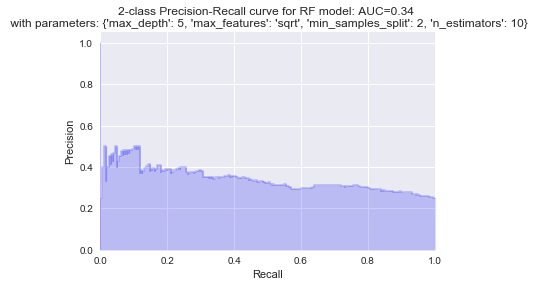

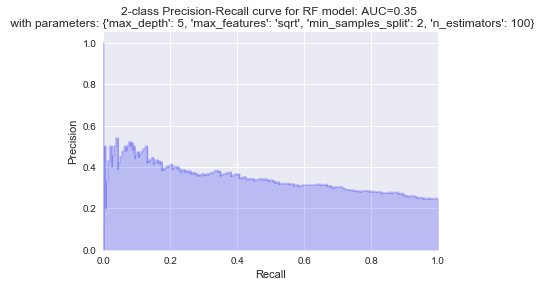

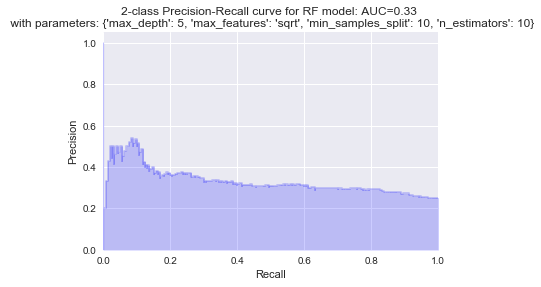

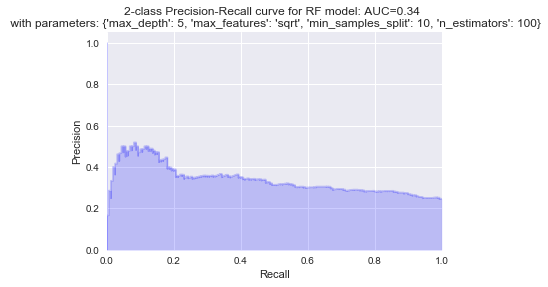

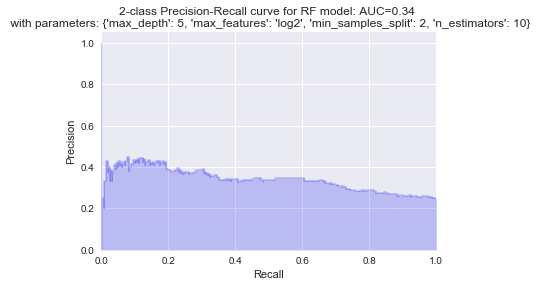

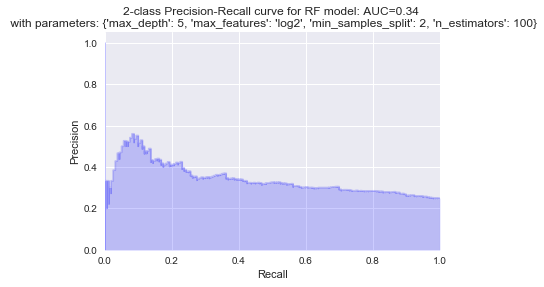

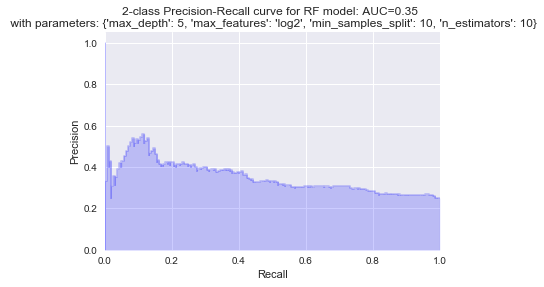

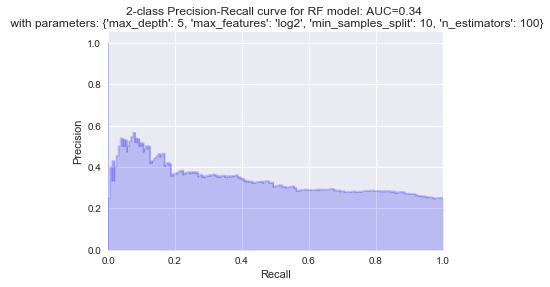

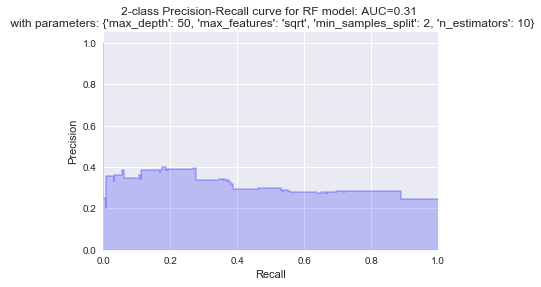

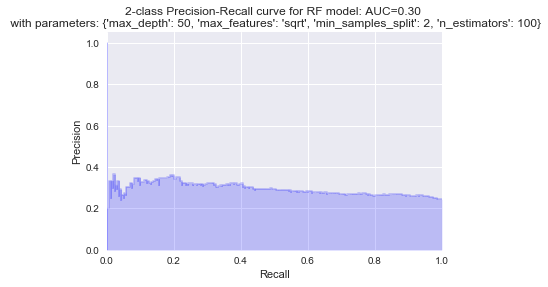

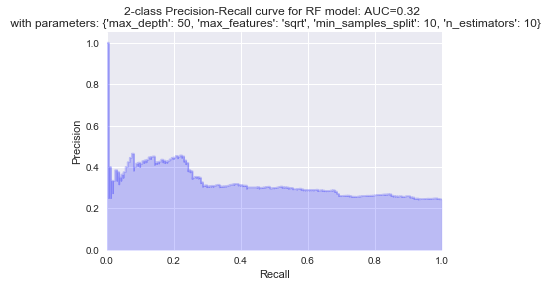

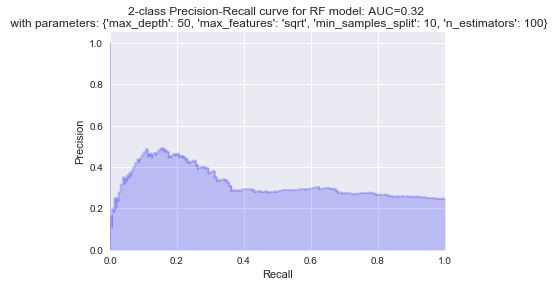

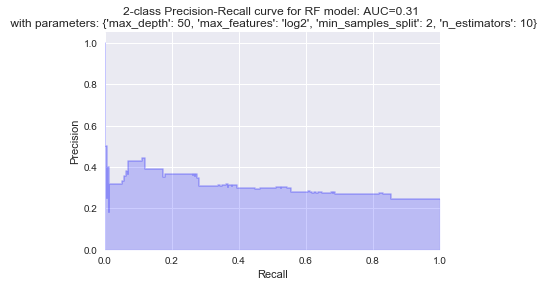

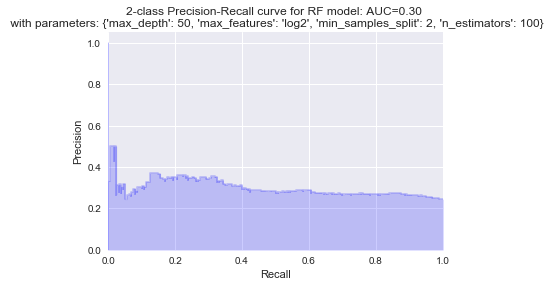

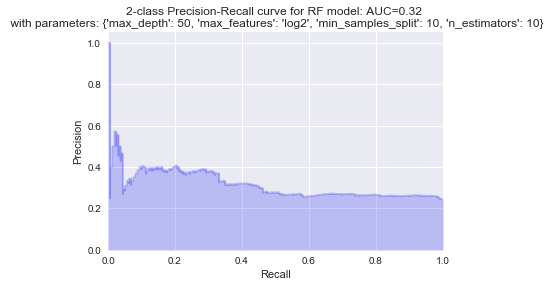

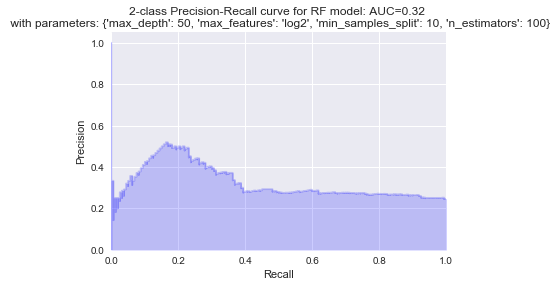

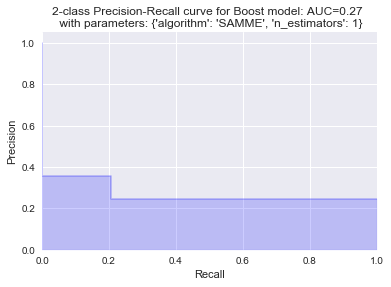

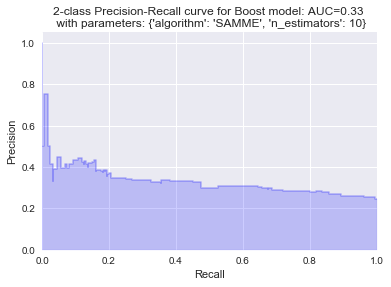

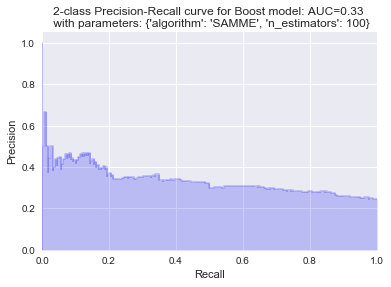

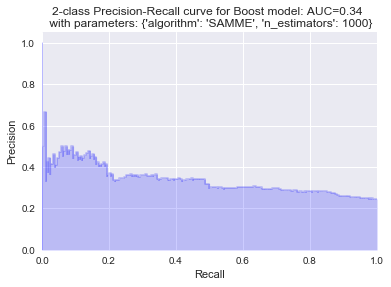

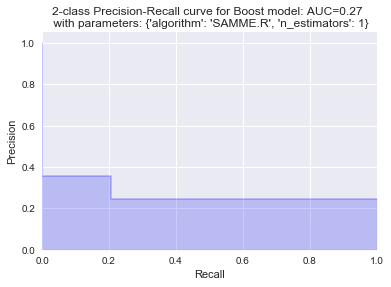

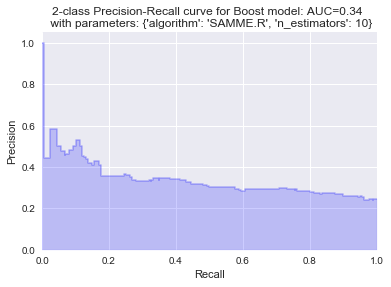

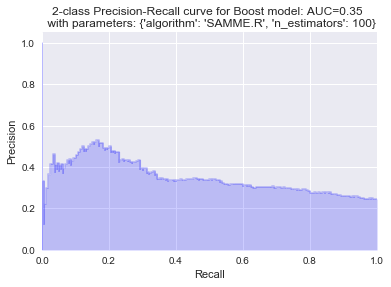

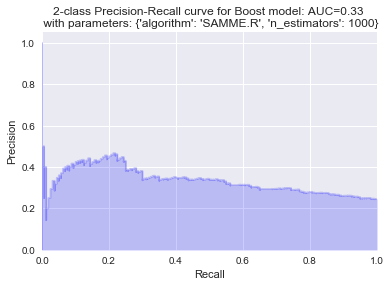

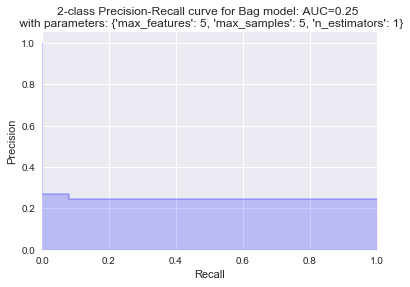

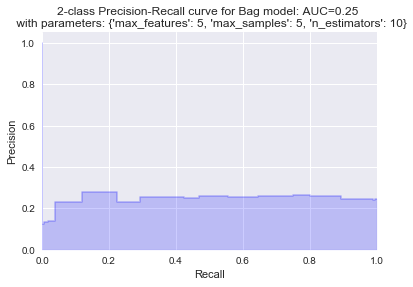

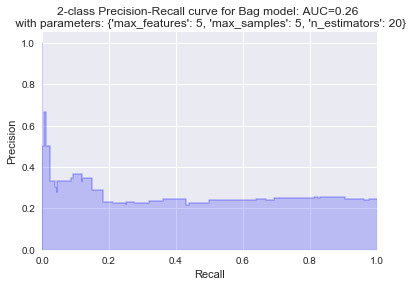

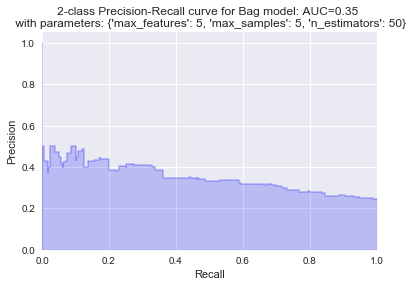

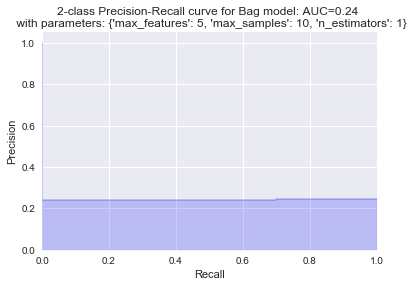

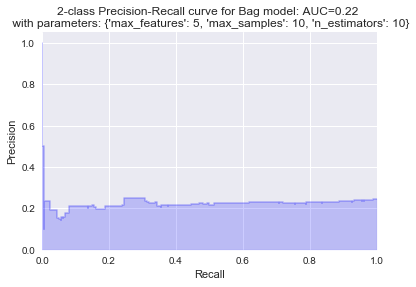

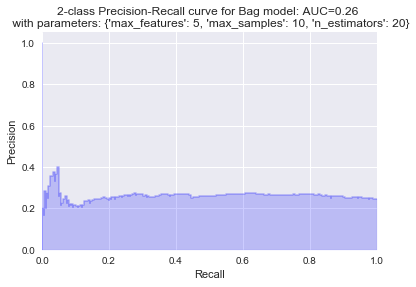

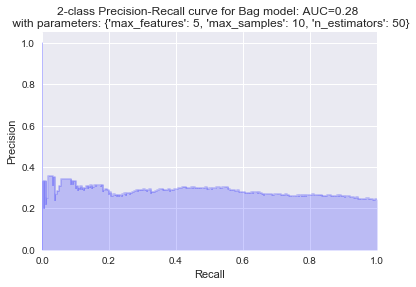

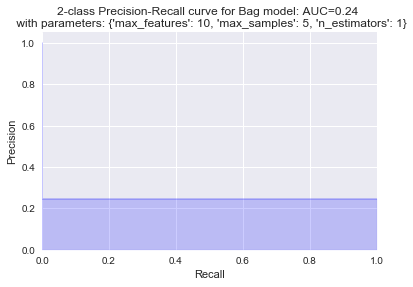

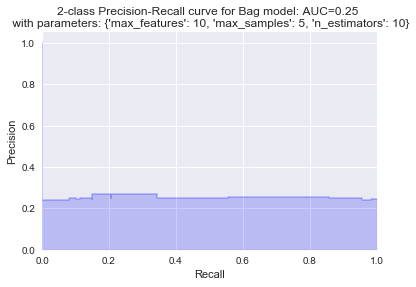

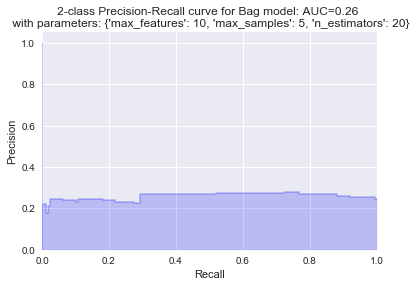

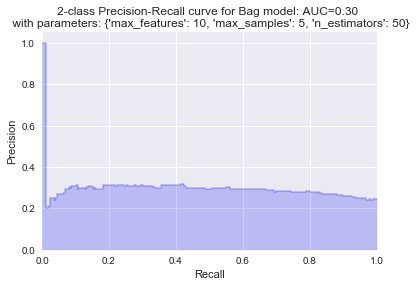

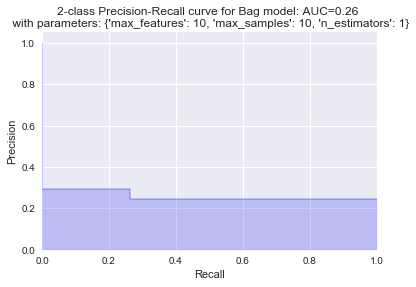

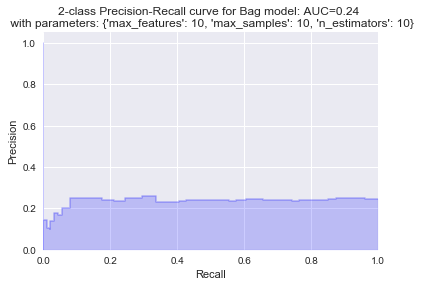

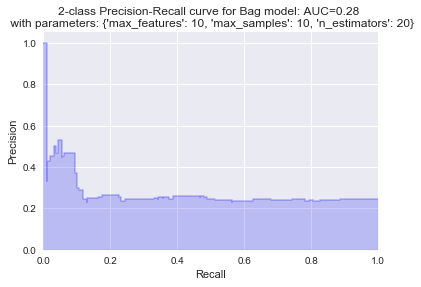

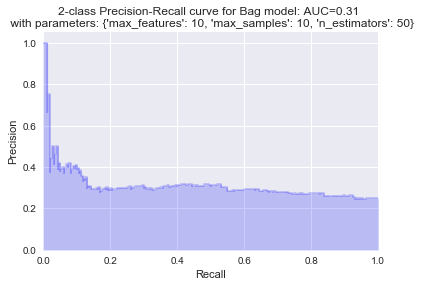

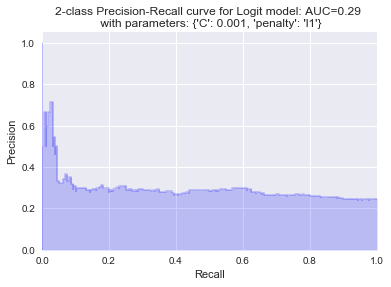

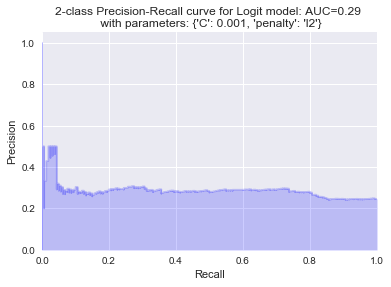

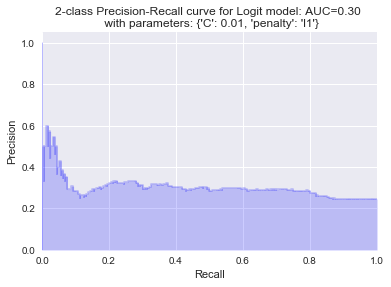

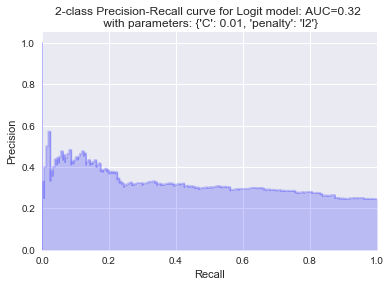

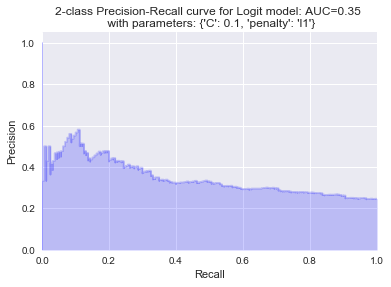

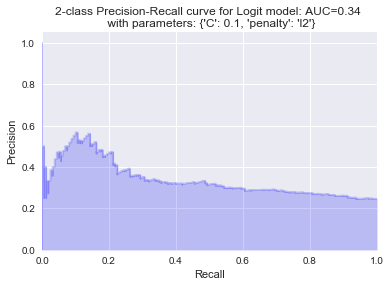

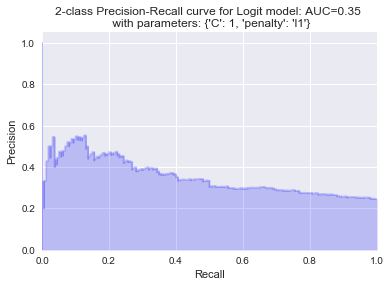

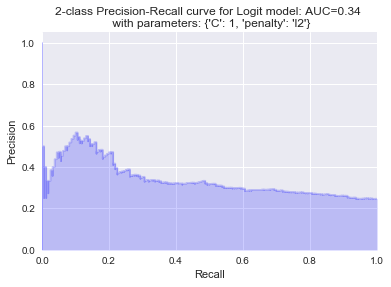

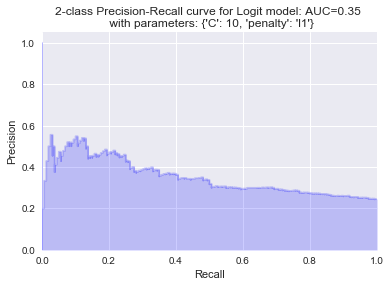

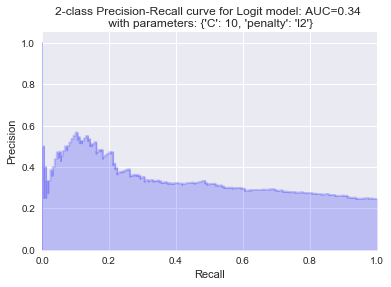

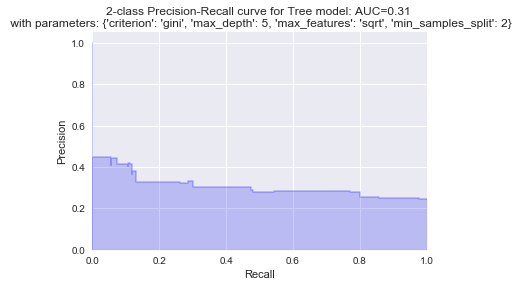

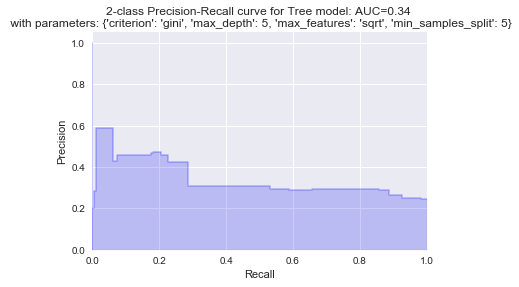

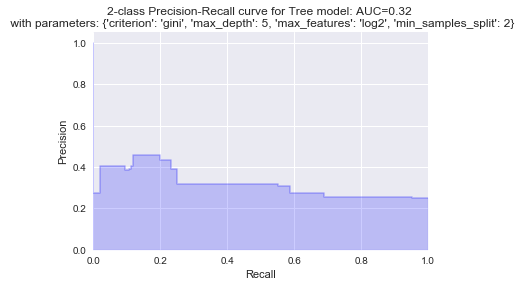

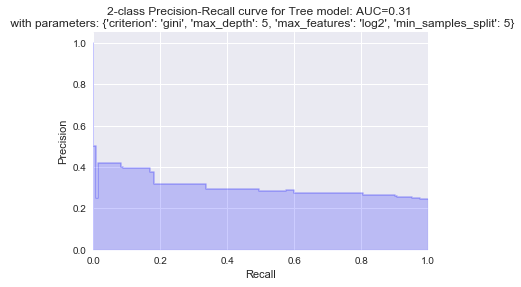

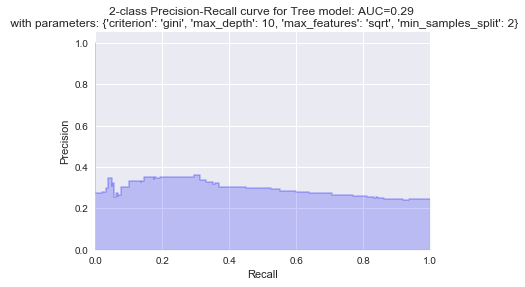

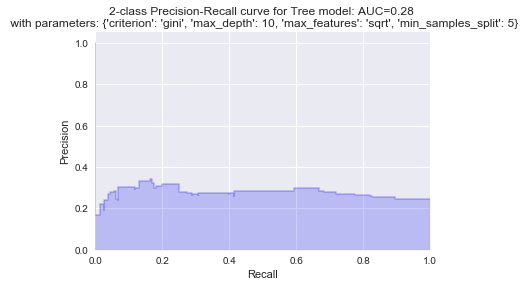

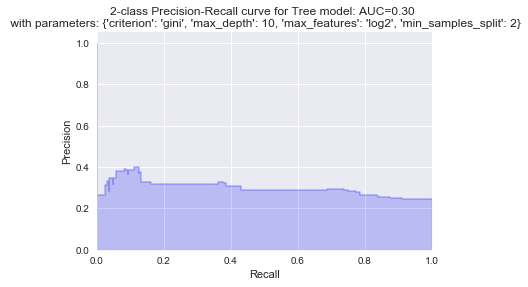

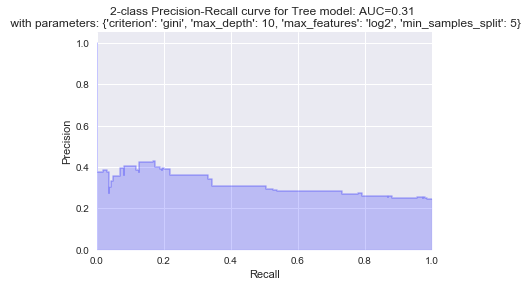

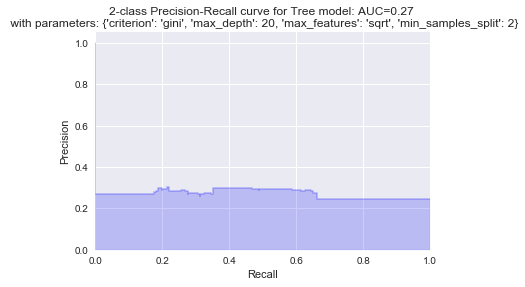

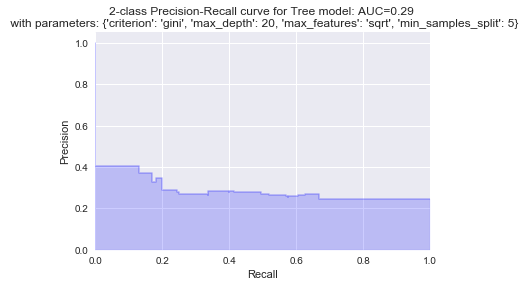

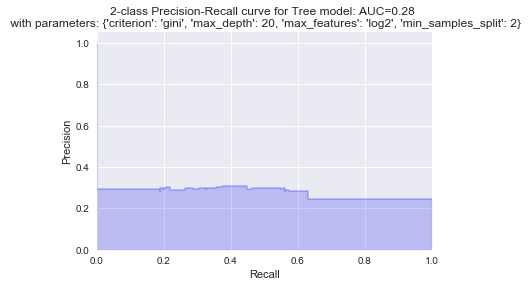

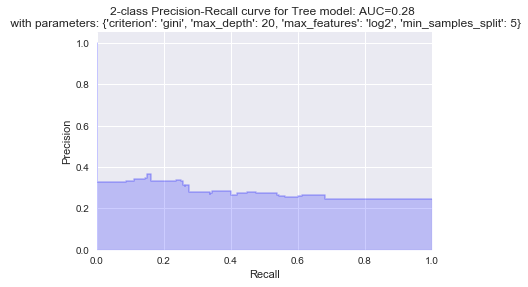

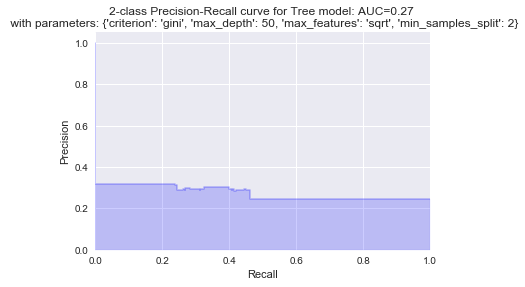

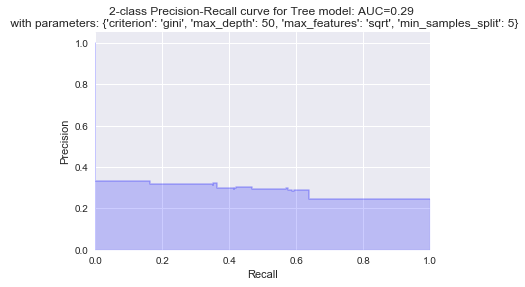

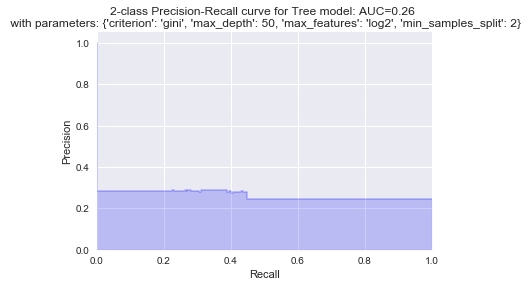

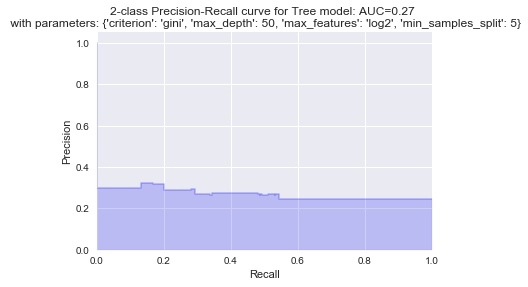

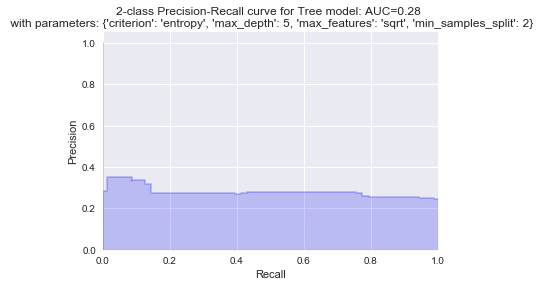

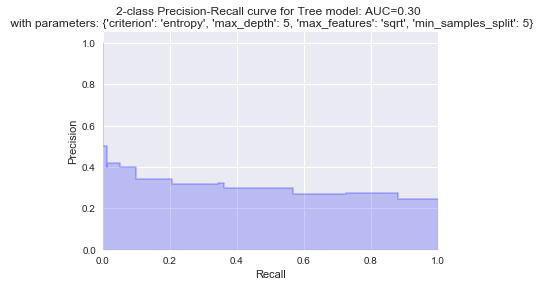

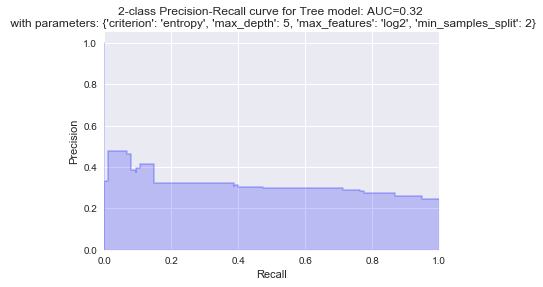

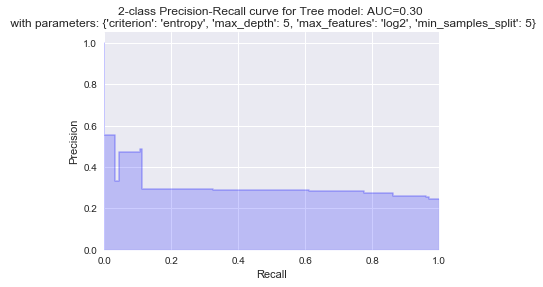

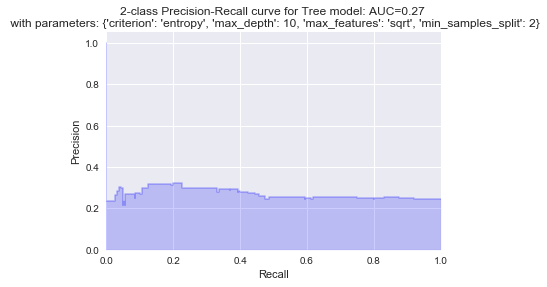

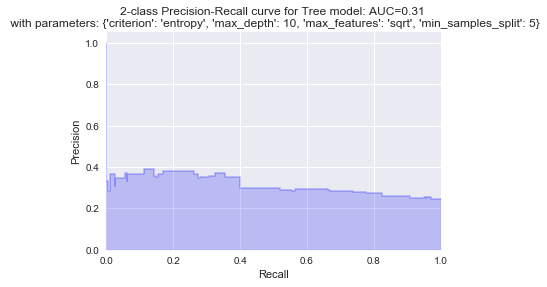

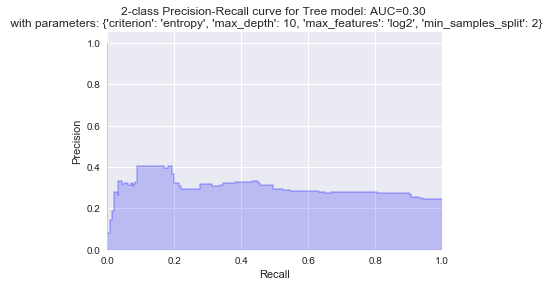

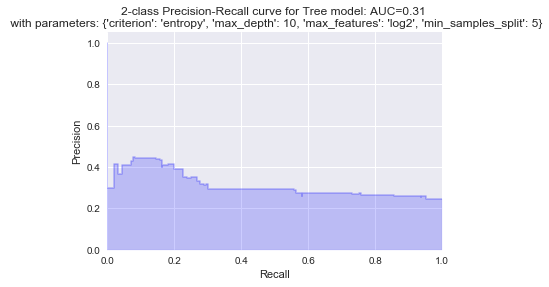

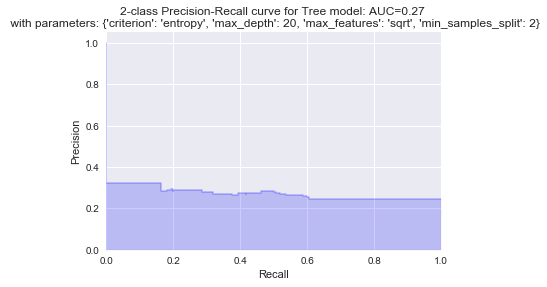

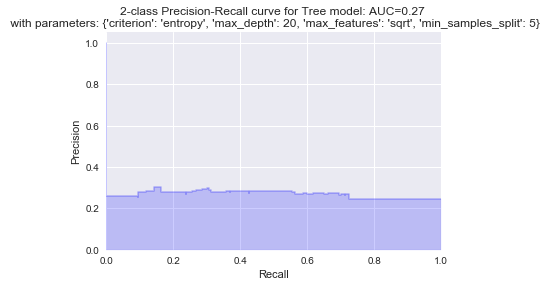

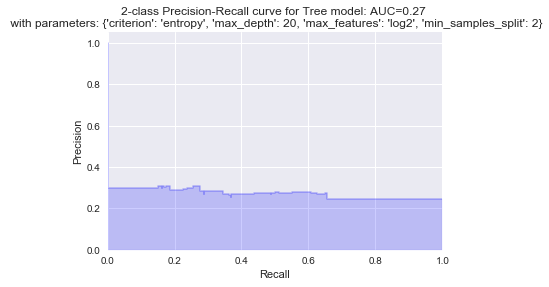

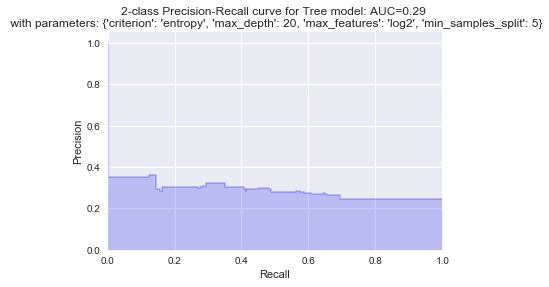

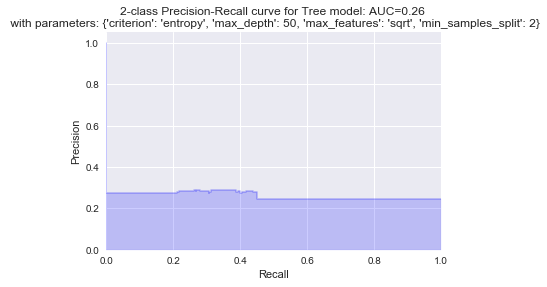

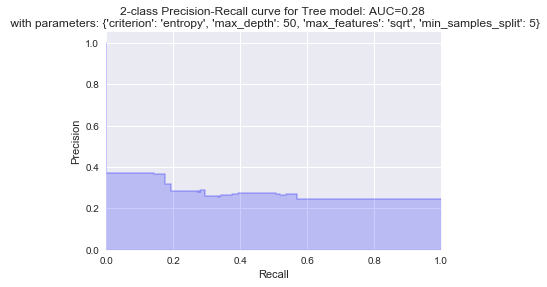

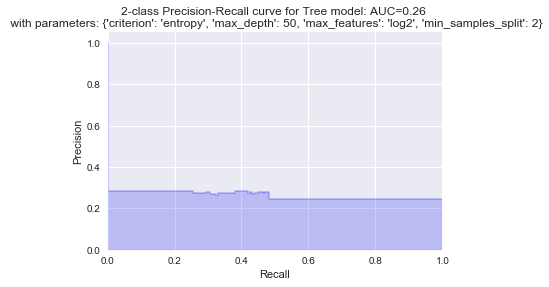

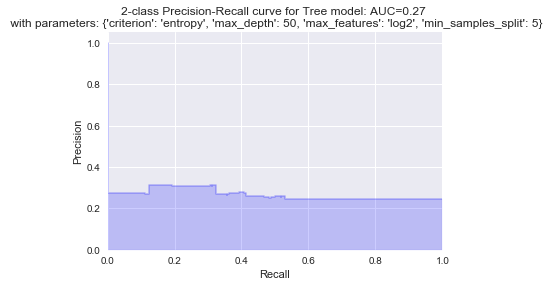

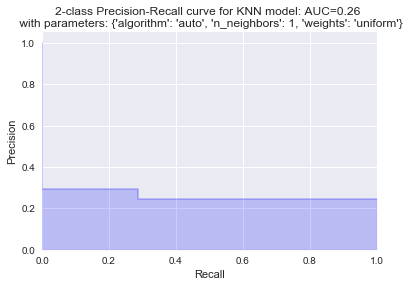

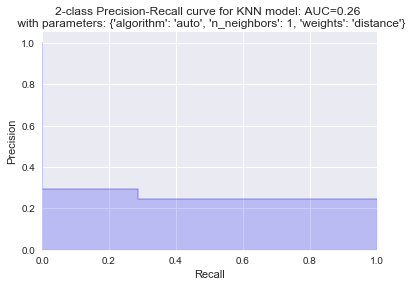

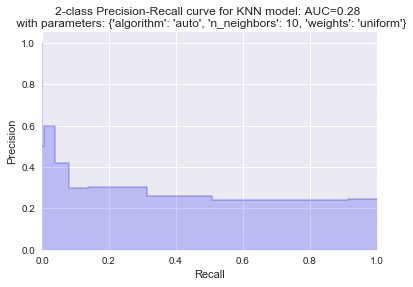

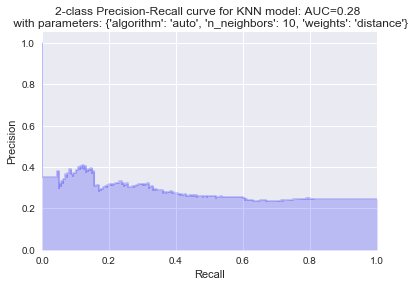

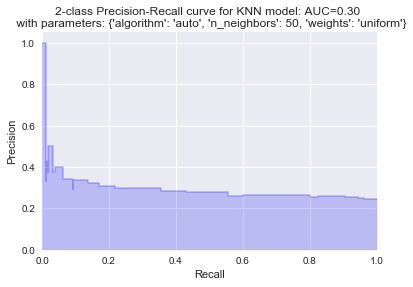

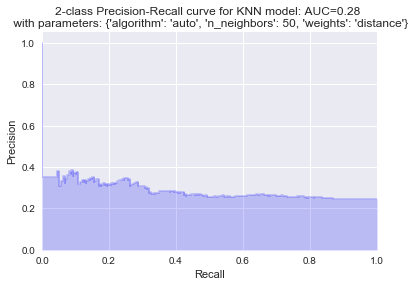

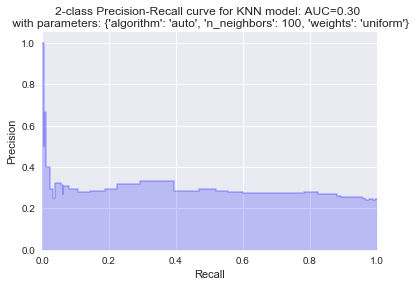

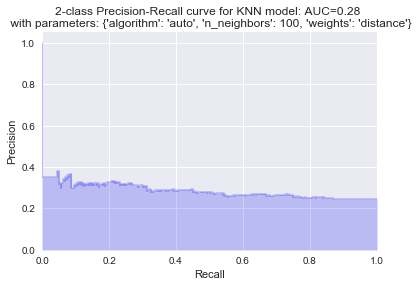

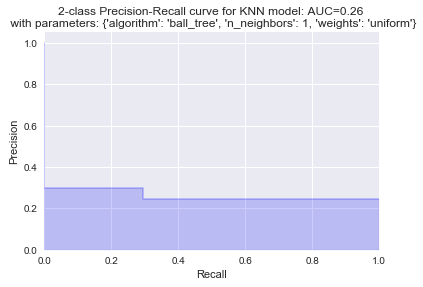

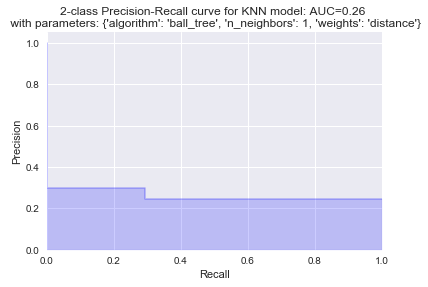

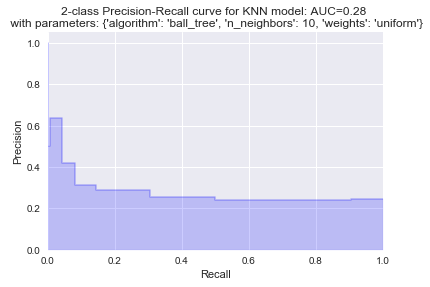

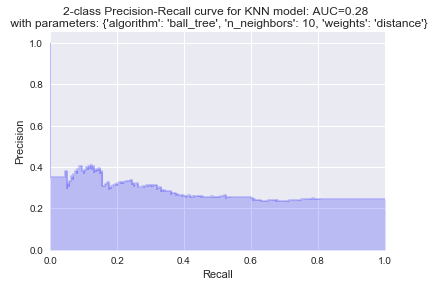

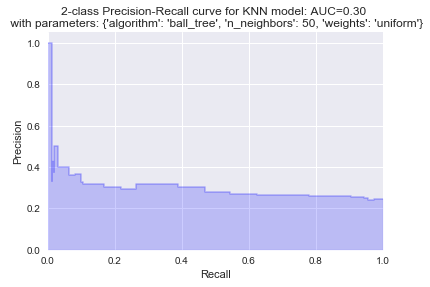

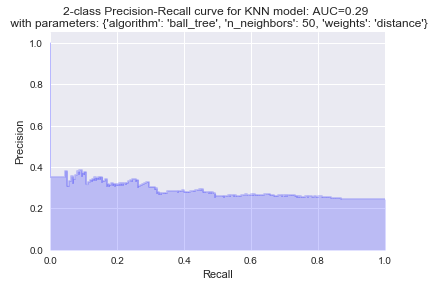

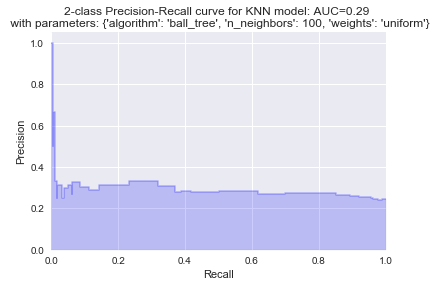

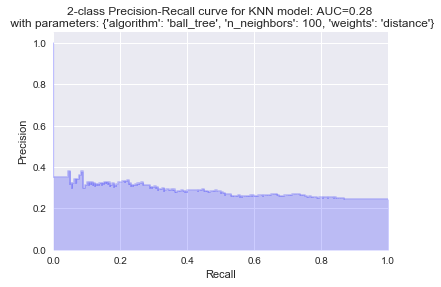

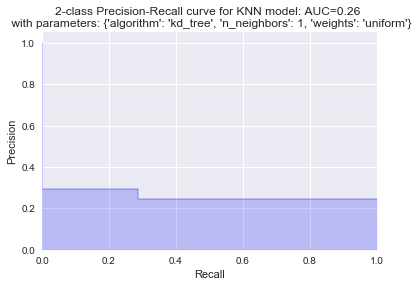

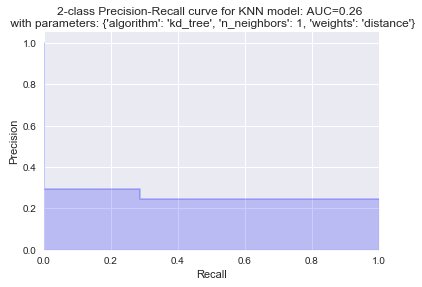

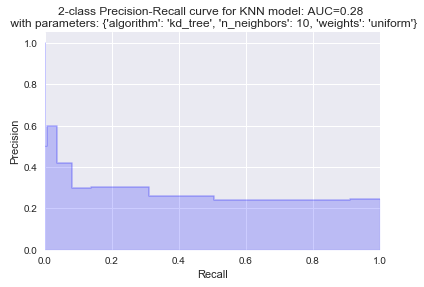

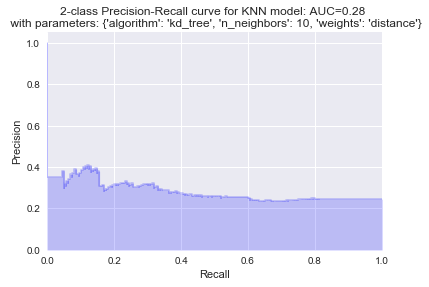

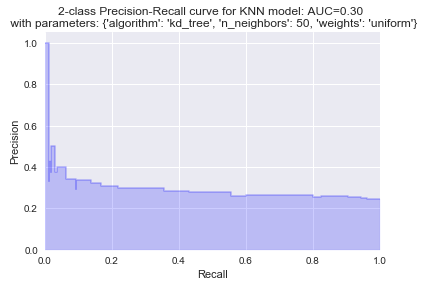

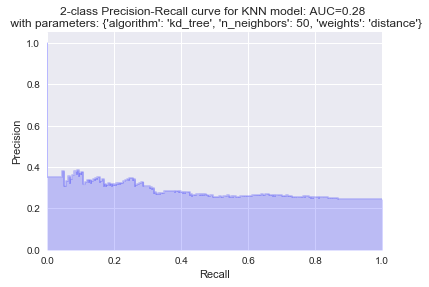

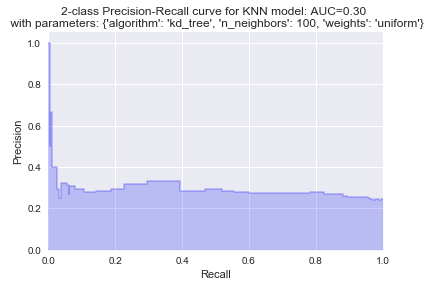

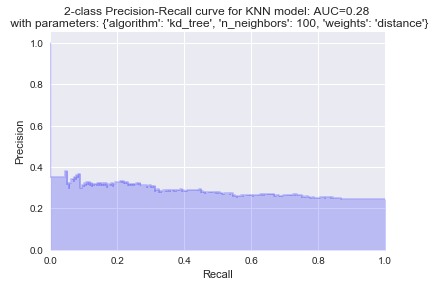

In [19]:
results = clf_loop(["RF", "Boost", "Bag", "Logit", "Tree", "KNN"], x_train, x_test, y_train, y_test)

In [20]:
display(results)

,model_type,parameters,accuracy,auc-roc,auc-pr,time,"precision,recall,f1 at_5","precision,recall,f1 at_10","precision,recall,f1 at_20"
0,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.753049,0.633209,0.342111,0.052529,"(0.5, 0.1, 0.16666666666666669)","(0.38461538461538464, 0.15625, 0.2222222222222...","(0.37404580152671757, 0.30625, 0.3367697594501..."
1,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.754573,0.622373,0.345390,0.223955,"(0.46875, 0.09375, 0.15625)","(0.4153846153846154, 0.16875, 0.24)","(0.366412213740458, 0.3, 0.32989690721649484)"
2,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.751524,0.615581,0.332356,0.040618,"(0.5, 0.1, 0.16666666666666669)","(0.36923076923076925, 0.15, 0.21333333333333332)","(0.35877862595419846, 0.29375, 0.3230240549828..."
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.753049,0.618926,0.338114,0.226790,"(0.46875, 0.09375, 0.15625)","(0.4461538461538462, 0.18125, 0.2577777777777778)","(0.35877862595419846, 0.29375, 0.3230240549828..."
4,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.751524,0.631319,0.339928,0.040442,"(0.40625, 0.08125, 0.13541666666666669)","(0.4307692307692308, 0.175, 0.24888888888888885)","(0.37404580152671757, 0.30625, 0.3367697594501..."
5,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.753049,0.618630,0.340799,0.242913,"(0.5, 0.1, 0.16666666666666669)","(0.4153846153846154, 0.16875, 0.24)","(0.33587786259541985, 0.275, 0.302405498281787)"
6,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.748476,0.629215,0.350056,0.038442,"(0.53125, 0.10625, 0.17708333333333334)","(0.4153846153846154, 0.16875, 0.24)","(0.3816793893129771, 0.3125, 0.3436426116838488)"
7,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.753049,0.612279,0.339271,0.243033,"(0.5, 0.1, 0.16666666666666669)","(0.4153846153846154, 0.16875, 0.24)","(0.3511450381679389, 0.2875, 0.3161512027491408)"
8,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.728659,0.599225,0.310490,0.065255,"(0.46875, 0.09375, 0.15625)","(0.4153846153846154, 0.16875, 0.24)","(0.40458015267175573, 0.33125, 0.3642611683848..."
9,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.710366,0.581697,0.295246,0.588202,"(0.25, 0.05, 0.08333333333333334)","(0.3230769230769231, 0.13125, 0.18666666666666...","(0.31297709923664124, 0.25625, 0.2817869415807..."


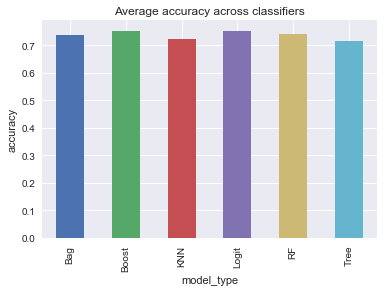

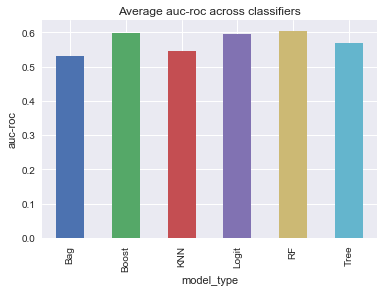

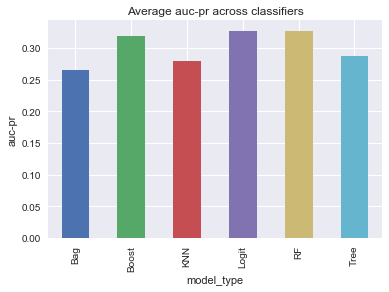

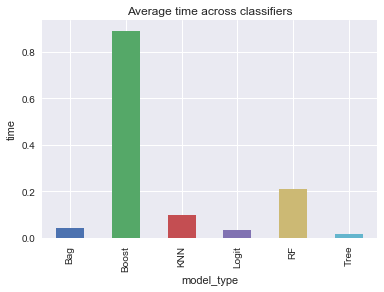

In [21]:
for item in ['accuracy', 'auc-roc','auc-pr','time']:
    plt.figure()
    results.groupby(['model_type'])[item].mean().plot(kind='bar', title='Average '+item+' across classifiers')
    plt.ylabel(item)

In [24]:
results.groupby('model_type')['accuracy'].nlargest(1)

model_type    
Bag         26    0.756098
Boost       18    0.757622
KNN         86    0.756098
Logit       42    0.757622
RF          15    0.759146
Tree        69    0.757622
Name: accuracy, dtype: float64

In [26]:
results.loc[[26, 18, 86, 42, 15, 69]].iloc[:,0:6]

,model_type,parameters,accuracy,auc-roc,auc-pr,time
26,Bag,"{'max_features': 5, 'max_samples': 5, 'n_estim...",0.756098,0.499383,0.262691,0.043628
18,Boost,"{'algorithm': 'SAMME', 'n_estimators': 100}",0.757622,0.612450,0.334851,0.267411
86,KNN,"{'algorithm': 'auto', 'n_neighbors': 50, 'weig...",0.756098,0.561549,0.296995,0.092401
42,Logit,"{'C': 0.01, 'penalty': 'l1'}",0.757622,0.580576,0.302507,0.018493
15,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",0.759146,0.591224,0.323907,0.459189
69,Tree,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.757622,0.588458,0.304556,0.012169
